In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

# Latent feature exploration with t-SNE
The CNN autoencoder compresses images to a 128×4×4 tensor bottleneck. This should encode a lot of interesting information about the fonts. Aim will be to extract features from this latent space and visualise them using t-SNE embedding

In [4]:
from fontcap_model import UNet, CNNAutoencoder, get_dataloaders
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from tqdm import tqdm
data_root = Path("..") / "data/fonts"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract the data with font/character labels

In [5]:
import io
import base64

def pil_to_base64(pil_img):
    buf = io.BytesIO()
    pil_img.save(buf, format='PNG')
    byte_im = buf.getvalue()
    return base64.b64encode(byte_im).decode('utf-8')


CHARSET = "abcdefghijklmnopqrstuvwxyz"


class EnrichedFontcapDataset(Dataset):
    """Dataset wrapper for scraped fonts"""
    def __init__(self, data_root: Path):
        self.data_root = Path(data_root)
        self.pairs = self._collect_pairs()

    def _collect_pairs(self):
        pairs = []
        for font_dir in self.data_root.iterdir():
            if not font_dir.is_dir():
                continue

            font_name = font_dir.name
            for c in CHARSET:
                upper_path = font_dir / f"{ord(c.upper())}.png"
                lower_path = font_dir / f"{ord(c.lower())}.png"
                if upper_path.exists() and lower_path.exists():
                    pairs.append((lower_path, upper_path, font_name, c))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lower_path, upper_path, font_name, char = self.pairs[idx]
        lower_img = Image.open(lower_path).convert('L')
        upper_img = Image.open(upper_path).convert('L')
        lower_arr = np.array(lower_img, dtype=np.float32) / 255.0
        upper_arr = np.array(upper_img, dtype=np.float32) / 255.0
        lower_tensor = torch.from_numpy(lower_arr).unsqueeze(0)
        upper_tensor = torch.from_numpy(upper_arr).unsqueeze(0)
        return lower_tensor, upper_tensor, font_name, char, pil_to_base64(lower_img.copy())

In [6]:
dataset = EnrichedFontcapDataset(data_root)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [10]:
def extract_latents(model, dataloader, num=500):
    model.eval()
    model.to(device)

    all_latents = []
    all_fonts = []
    all_chars = []
    all_b64s = []

    with torch.no_grad():
        # NEED A LIMITER IN HERE
        limited = iter(dataloader)
        # for lower_batch, _, font_names, chars, b64s in dataloader:
        for i in range(num):
            lower_batch, _, font_names, chars, b64s = next(limited)
            lower_batch = lower_batch.to(device)

            # Forward pass through encoder
            encoded = model.encoder(lower_batch)              # [B, C, H, W]
            latent_vecs = encoded.view(encoded.size(0), -1)   # Flatten to [B, N]

            all_latents.append(latent_vecs.cpu())
            all_fonts.extend(font_names)
            all_chars.extend(chars)
            all_b64s.extend(b64s)

    # Stack latent vectors into single (N, D) array
    latents = torch.cat(all_latents, dim=0).numpy()

    return latents, all_fonts, all_chars, all_b64s

# Import the trained CNN

In [11]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_100_epochs.pt"))

C:\Users\benla\AppData\Local\Temp\ipykernel_18064\1696753724.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_100_epochs.pt"))


<All keys matched successfully>

In [14]:
lt, font_labels, char_labels, images = extract_latents(model, dataloader)

# Calculate and plot the t-SNE embeddings

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
def run_tsne(latents, dim=2, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=dim, perplexity=perplexity, max_iter=n_iter, random_state=42)
    return tsne.fit_transform(latents)

In [17]:
def plot_tsne_2d(latents_2d, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab20', s=5, alpha=0.7)
    plt.title('t-SNE Projection of Latents')
    plt.xlabel('t-SNE-1')
    plt.ylabel('t-SNE-2')
    # plt.colorbar(scatter, ticks=range(len(font_to_id)), label='Font ID')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_tsne_3d(latents_3d, labels):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2],
        c=labels, cmap='tab20', s=8, alpha=0.7
    )

    ax.set_title('t-SNE Projection (3D) of Font Latents')
    ax.set_xlabel('t-SNE-1')
    ax.set_ylabel('t-SNE-2')
    ax.set_zlabel('t-SNE-3')
    # plt.colorbar(sc, label="Font ID")
    plt.tight_layout()
    plt.show()

## Run the 2D tSNE embedding
Need to encode the colours and fonts as numbers

In [18]:
embedding2d = run_tsne(lt, dim=2, n_iter=500)

C:\Users\benla\AppData\Local\Temp\ipykernel_18064\198383897.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab20', s=5, alpha=0.7)


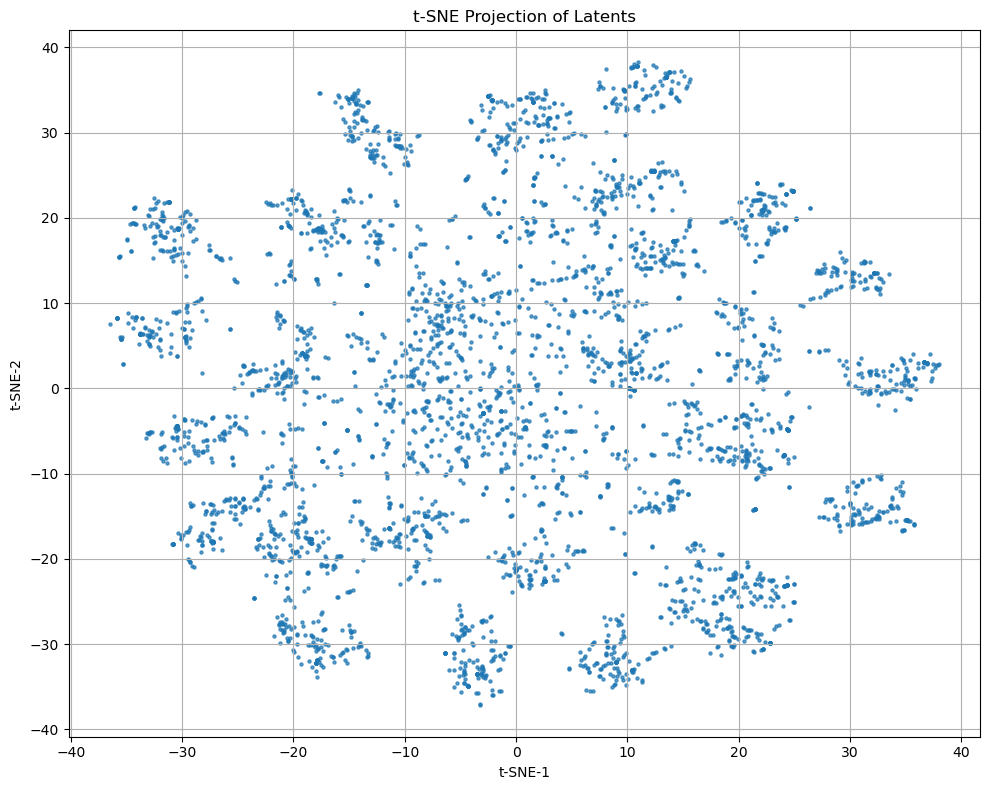

In [21]:
plot_tsne_2d(embedding2d, None)

## Examine individual letters

In [50]:
char_to_int = list(set(char_labels))
char_to_int.sort()
char_mapper = {c: char_to_int.index(c) for c in char_to_int}
char_colour_labels = np.array([char_mapper[l] for l in char_labels])

In [53]:
char_colour_labels[:10]

array([25, 15,  2, 13, 23, 23, 20, 11, 23, 14])

In [ ]:
valid_letters = ['a', 'b']
valid_idx = char_labels.where
idx = 

ValueError: 'c' argument has 4000 elements, which is inconsistent with 'x' and 'y' with size 0.

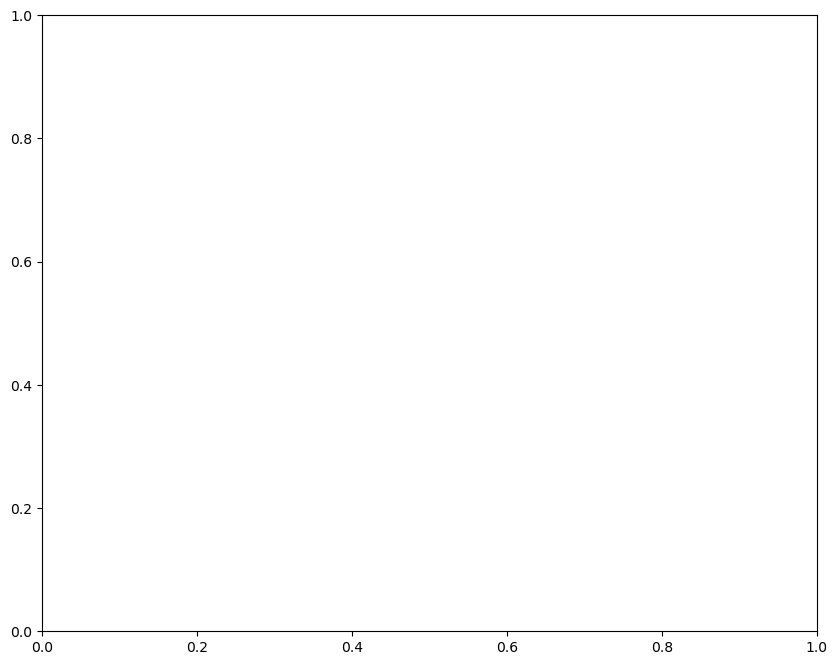

In [49]:
plot_tsne_restricted(embedding2d, ['a', 'b'])

In [55]:
embedding3d = run_tsne(lt, dim=3, n_iter=500)

## Better plotting, with hover

In [28]:
import pandas as pd
import plotly.express as px

def plot_tsne_2d_with_images(latents_2d, chars, images_b64):
    hover_templates = [
        # f"<b>Char:</b> {c}<br><img src='data:image/png;base64,{b64}' width='32' height='32'>"
        f"<b>Char:</b> {c}<br>"
        for c, b64 in zip(chars, images_b64)
    ]

    df = pd.DataFrame({
        'x': latents_2d[:, 0],
        'y': latents_2d[:, 1],
        'char': chars,
        'hover': hover_templates
    })

    fig = px.scatter(
        df, x='x', y='y', color='char',
        hover_name='char',
        hover_data={'x': False, 'y': False, 'char': False, 'hover': False},
        labels={'char': 'Character'},
    )

    fig.update_traces(marker=dict(size=6), hovertemplate=df['hover'])
    fig.update_layout(
        title='2D t-SNE',
        xaxis_title='t-SNE 1',
        yaxis_title='t-SNE 2',
        legend_title='Character'
    )
    fig.show()

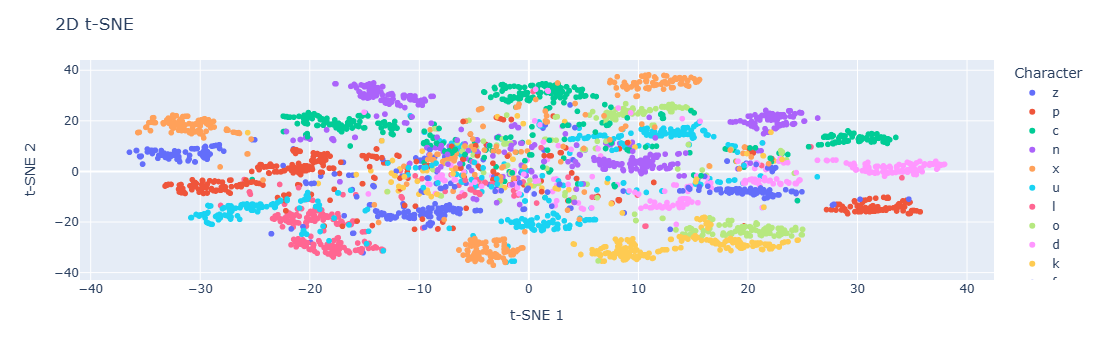

In [54]:
plot_tsne_2d_with_images(embedding2d, char_labels, images)